In [1]:
import numpy as np
import pandas as pd
import os
import json
import librosa
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
import pickle

2025-09-04 14:13:47.208077: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
sr = 22050
TOTAL_SAMPLES = 29 * sr

NUM_SLICES = 10
SAMPLES_PER_SLICE = int(TOTAL_SAMPLES / NUM_SLICES)

In [3]:
def augment_audio(slice_song, sr):
    # Time stretching
    stretch_rate = np.random.uniform(0.8, 1.2)
    slice_song_stretched = librosa.effects.time_stretch(slice_song,rate=stretch_rate)

    # Pitch shifting
    pitch_shift = np.random.randint(-2, 3)  # Shift between -2 and +2 semitones
    slice_song_pitched = librosa.effects.pitch_shift(slice_song_stretched, sr=sr, n_steps=pitch_shift)

    # Adding noise
    noise_factor = 0.005
    noise = np.random.randn(len(slice_song_pitched))
    slice_song_noisy = slice_song_pitched + noise_factor * noise

    # Random volume adjustment
    volume_factor = np.random.uniform(0.5, 1.5)
    slice_song_augmented = slice_song_noisy * volume_factor

    return slice_song_augmented

In [4]:
def preprocess_data_MFCC(source_path, json_path):

    # Dictionary of labels and processed data.
    mydict = {
        "labels": [],
        "mfcc": []
        }

    # Browse each file, slice it and generate the 128 band mfcc for each slice.
    for i, (dirpath,dirname, filenames) in enumerate(os.walk(source_path)):
        for file in filenames:
            # exclude a corrupted wav file that makes everything crash.
            if os.path.join(dirpath, file) != 'genres_original/jazz/jazz.00054.wav':
                song, sr = librosa.load(os.path.join(dirpath, file), duration=29)
                for s in range(NUM_SLICES):
                    start_sample = SAMPLES_PER_SLICE * s
                    end_sample = start_sample + SAMPLES_PER_SLICE

                    slice_song=song[start_sample:end_sample]

                    #augmented_slice=augment_audio(slice_song,sr)

                    # Compute MFCC
                    mfcc = librosa.feature.mfcc(y=slice_song, sr=sr, n_mfcc=128)
                    mfcc = mfcc.T

                    mydict["labels"].append(i-1)
                    mydict["mfcc"].append(mfcc.tolist())
            else:
                pass

    # Write the dictionary in a json file.    
    with open(json_path, 'w') as f:
        json.dump(mydict, f)
    f.close()

In [5]:
def preprocess_data_STFT(source_path, json_path):

    # Dictionary of labels and processed data.
    mydict = {
        "labels": [],
        "stft": [] 
        }

    # Browse each file, slice it and generate the 128 band mfcc for each slice.
    for i, (dirpath,dirname, filenames) in enumerate(os.walk(source_path)):
        for file in filenames:
            # exclude a corrupted wav file that makes everything crash.
            if os.path.join(dirpath, file) != 'genres_original/jazz/jazz.00054.wav':
                song, sr = librosa.load(os.path.join(dirpath, file), duration=29)
                for s in range(NUM_SLICES):
                    start_sample = SAMPLES_PER_SLICE * s
                    end_sample = start_sample + SAMPLES_PER_SLICE

                    slice_song=song[start_sample:end_sample]

                    #augmented_slice=augment_audio(slice_song,sr)

                    # Compute STFT
                    stft = np.abs(librosa.stft(slice_song,n_fft=256,hop_length=512))
                    stft = stft.T

                    mydict["labels"].append(i-1)
                    mydict["stft"].append(stft.tolist())
            else:
                pass

    # Write the dictionary in a json file.    
    with open(json_path, 'w') as f:
        json.dump(mydict, f)
    f.close()

In [6]:
def load_data_MFCC(json_path):
    # Load the JSON data from the file
    with open(json_path, 'r') as f:
        data = json.load(f)

    x = np.array(data["mfcc"])
    y = np.array(data["labels"])

    return x, y

In [7]:
def load_data_STFT(json_path):
    # Load the JSON data from the file
    with open(json_path, 'r') as f:
        data = json.load(f)

    x = np.array(data["stft"])
    y = np.array(data["labels"])

    return x, y

In [8]:
def prepare_datasets(inputs, targets, split_size):
    
    # Creating a validation set and a test set.
    inputs_train, inputs_val, targets_train, targets_val = train_test_split(inputs, targets, test_size=split_size)
    inputs_train, inputs_test, targets_train, targets_test = train_test_split(inputs_train, targets_train, test_size=split_size)
    
    # Our CNN model expects 3D input shape.
    inputs_train = inputs_train[..., np.newaxis]
    inputs_val = inputs_val[..., np.newaxis]
    inputs_test = inputs_test[..., np.newaxis]
    
    return inputs_train, inputs_val, inputs_test, targets_train, targets_val, targets_test

In [26]:
def design_model(input_shape_MFCC, input_shape_STFT):

    # Define the MFCC branch (x1)
    input_MFCC = tf.keras.Input(shape=input_shape_MFCC)
    x1 = tf.keras.layers.Conv2D(20, (16, 16), activation='relu')(input_MFCC)
    x1 = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x1)
    x1 = tf.keras.layers.BatchNormalization()(x1)
    
    x1 = tf.keras.layers.Conv2D(22, (13, 13), activation='relu', padding='same')(x1)
    x1 = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x1)
    x1 = tf.keras.layers.BatchNormalization()(x1)
    
    x1 = tf.keras.layers.Conv2D(26, (8, 8), activation='relu', padding='same')(x1)
    x1 = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x1)
    x1 = tf.keras.layers.BatchNormalization()(x1)

    #x1 = tf.keras.layers.Conv2D(38, (7, 7), activation='relu', padding='same')(x1)
    #x1 = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x1)
    #x1 = tf.keras.layers.BatchNormalization()(x1)

    #x1 = tf.keras.layers.Conv2D(39, (4, 4), activation='relu', padding='same')(x1)
    #x1 = tf.keras.layers.AveragePooling2D((2, 2), padding='same')(x1)
    #x1 = tf.keras.layers.BatchNormalization()(x1)
    x1 = tf.keras.layers.Dropout(0.5)(x1)
    
    x1 = tf.keras.layers.Flatten()(x1)
    x1 = tf.keras.layers.Dense(200, activation='relu')(x1)
    
    # Define the STFT branch (x2)
    input_STFT = tf.keras.Input(shape=input_shape_STFT)
    x2 = tf.keras.layers.Conv2D(31, (15, 15), activation='relu')(input_STFT)
    x2 = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x2)
    x2 = tf.keras.layers.BatchNormalization()(x2)
    
    x2 = tf.keras.layers.Conv2D(38, (11, 11), activation='relu', padding='same')(x2)
    x2 = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x2)
    x2 = tf.keras.layers.BatchNormalization()(x2)
    
    x2 = tf.keras.layers.Conv2D(43, (9, 9), activation='relu', padding='same')(x2)
    x2 = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x2)
    x2 = tf.keras.layers.BatchNormalization()(x2)

    #x2 = tf.keras.layers.Conv2D(57, (6, 6), activation='relu', padding='same')(x2)
    #x2 = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x2)
    #x2 = tf.keras.layers.BatchNormalization()(x2)

    #x2 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x2)
    #x2 = tf.keras.layers.AveragePooling2D((2, 2), padding='same')(x2)
    #x2 = tf.keras.layers.BatchNormalization()(x2)
    x2 = tf.keras.layers.Dropout(0.5)(x2)
    
    x2 = tf.keras.layers.Flatten()(x2)
    x2 = tf.keras.layers.Dense(200, activation='relu')(x2)

    # Concatenate both branches
    merged = tf.keras.layers.Concatenate()([x1, x2])

    # Output layer
    output = tf.keras.layers.Dense(4, activation='softmax')(merged)

    # Create the model
    model = tf.keras.Model(inputs=[input_MFCC, input_STFT], outputs=output)
    
    return model

In [27]:
def make_prediction(model, X, y, idx):
    
    genre_dict = {
        0 : "blues",
        1 : "classical",
        2 : "country",
        3 : "disco",
        4 : "hiphop",
        5 : "jazz",
        6 : "metal",
        7 : "pop",
        8 : "reggae",
        9 : "rock",
        }
        
    predictions = model.predict(X)
    genre = np.argmax(predictions[idx])
    
    print("\n---Now testing the model for one audio file---\nThe model predicts: {}, and ground truth is: {}.\n".format(genre_dict[genre], genre_dict[y[idx]]))

In [28]:
def plot_performance(hist):
    
    acc = hist.history['acc']
    val_acc = hist.history['val_acc']
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']

    epochs = range(len(acc))

    plt.plot(epochs, acc, 'r', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()

    plt.plot(epochs, loss, 'r', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

def plot_history(hist):
    plt.figure(figsize=(20,15))
    fig, axs = plt.subplots(2)
    # accuracy subplot
    axs[0].plot(hist.history["acc"], label="train accuracy")
    axs[0].plot(hist.history["val_acc"], label="test accuracy")    
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")
    
    # Error subplot
    axs[1].plot(hist.history["loss"], label="train error")
    axs[1].plot(hist.history["val_loss"], label="test error")    
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")
    
    plt.show()

In [29]:
if not os.path.exists("mfcc.json"):
    preprocess_data_MFCC(source_path="genres_original", json_path="mfcc.json")
else:
    print("File already exists, skipping preprocessing.")

File already exists, skipping preprocessing.


In [30]:
if not os.path.exists("stft.json"):
    preprocess_data_STFT(source_path="genres_original", json_path="stft.json")
else:
    print("File already exists, skipping preprocessing.")

File already exists, skipping preprocessing.


In [31]:
inputs_MFCC, targets_MFCC = load_data_MFCC(json_path="mfcc.json")

In [32]:
inputs_MFCC.shape

(4000, 125, 128)

In [ ]:
inputs_STFT, targets_STFT= load_data_STFT(json_path="stft.json")

In [ ]:
inputs_STFT.shape

(4000, 125, 129)

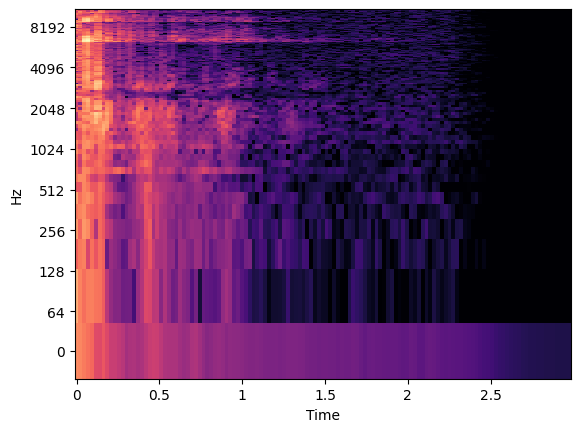

In [ ]:
fig, ax = plt.subplots()
librosa.display.specshow(librosa.amplitude_to_db(inputs_STFT[0],ref=np.max),y_axis="log",x_axis="time",ax=ax)

In [ ]:
# Use either targets_STFT or targets_MFCC as the labels (they should be the same)
y = targets_STFT  # Assuming both taprint("File already exists, skipping preprocessing.")rget arrays are identical

# Ensure the labels are one-hot encoded for classification
from sklearn.preprocessing import LabelBinarizer
label_binarizer = LabelBinarizer()
y_onehot = label_binarizer.fit_transform(y)

# Split the data into training and validation sets
from sklearn.model_selection import train_test_split
inputs_MFCC_train, inputs_MFCC_val, inputs_STFT_train, inputs_STFT_val, y_train, y_val = train_test_split(
    inputs_MFCC, inputs_STFT, y_onehot, test_size=0.2, random_state=42
)

# Create the model
input_shape_MFCC = (inputs_MFCC_train.shape[1],inputs_MFCC_train.shape[2],1)  # Shape of MFCC input
input_shape_STFT = (inputs_STFT_train.shape[1],inputs_STFT_train.shape[2],1)  # Shape of STFT input
model = design_model(input_shape_MFCC, input_shape_STFT)

model.compile(optimizer = tf.keras.optimizers.Adam(),
                     loss='categorical_crossentropy',
                     metrics = ['acc']
                     )


I0000 00:00:1757016859.347913   12011 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1279 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3070 Ti, pci bus id: 0000:2b:00.0, compute capability: 8.6


In [ ]:
model.summary() 

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 125, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 125, 129,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 110, 113,  │      5,140 │ input_layer[0][0] │
│                     │ 20)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 111, 115,  │      7,006 │ input_layer_1[0]… │
│                     │ 31)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 55, 57,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 20)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 56, 58,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 31)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 55, 57,    │         80 │ max_pooling2d[0]… │
│ (BatchNormalizatio… │ 20)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 56, 58,    │        124 │ max_pooling2d_3[… │
│ (BatchNormalizatio… │ 31)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 55, 57,    │     74,382 │ batch_normalizat… │
│                     │ 22)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 56, 58,    │    142,576 │ batch_normalizat… │
│                     │ 38)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 28, 29,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 22)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 28, 29,    │          0 │ conv2d_4[0][0]    │
│ (MaxPooling2D)      │ 38)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 29,    │         88 │ max_pooling2d_1[… │
│ (BatchNormalizatio… │ 22)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 29,    │        152 │ max_pooling2d_4[… │
│ (BatchNormalizatio… │ 38)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 28, 29,    │     36,634 │ batch_normalizat… │
│                     │ 26)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 28, 29,    │    132,397 │ batch_normalizat… │
│                     │ 43)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 14, 15,    │          0 │ conv2d_2[0][0]  

 Total params: 3,298,859 (12.58 MB)

 Trainable params: 3,298,499 (12.58 MB)

 Non-trainable params: 360 (1.41 KB)

In [ ]:
history = model.fit(
    [inputs_MFCC_train, inputs_STFT_train],  # The two inputs for the model
    y_train,  # The target labels
    validation_data=([inputs_MFCC_val, inputs_STFT_val], y_val),
    epochs=10,
    batch_size=32
    )


Epoch 1/10


2025-09-04 14:14:22.378635: I external/local_xla/xla/service/service.cc:163] XLA service 0x7971c4019aa0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-09-04 14:14:22.378655: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti, Compute Capability 8.6
2025-09-04 14:14:22.438044: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-09-04 14:14:22.766014: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91200
2025-09-04 14:14:22.826513: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-09-04 14:14:22.826536: 

  7/100 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - acc: 0.4506 - loss: 3.6287

I0000 00:00:1757016871.897590   12152 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 99/100 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - acc: 0.7752 - loss: 1.3505

2025-09-04 14:14:34.893094: W external/local_xla/xla/tsl/framework/bfc_allocator.cc:310] Allocator (GPU_0_bfc) ran out of memory trying to allocate 515.90MiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


100/100 ━━━━━━━━━━━━━━━━━━━━ 16s 43ms/step - acc: 0.8700 - loss: 0.6260 - val_acc: 0.8687 - val_loss: 0.9545
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - acc: 0.9488 - loss: 0.1542 - val_acc: 0.8512 - val_loss: 0.6950
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - acc: 0.9650 - loss: 0.1071 - val_acc: 0.9438 - val_loss: 0.2228
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - acc: 0.9712 - loss: 0.0914 - val_acc: 0.8712 - val_loss: 0.4350
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - acc: 0.9894 - loss: 0.0324 - val_acc: 0.9137 - val_loss: 0.3574
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - acc: 0.9847 - loss: 0.0501 - val_acc: 0.9400 - val_loss: 0.1881
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - acc: 0.9800 - loss: 0.0697 - val_acc: 0.8012 - val_loss: 1.4929
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - acc: 0.9822 - loss: 0.0545 - val_acc: 0.9750 - val_loss: 0.1143
Epoch 9/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - acc

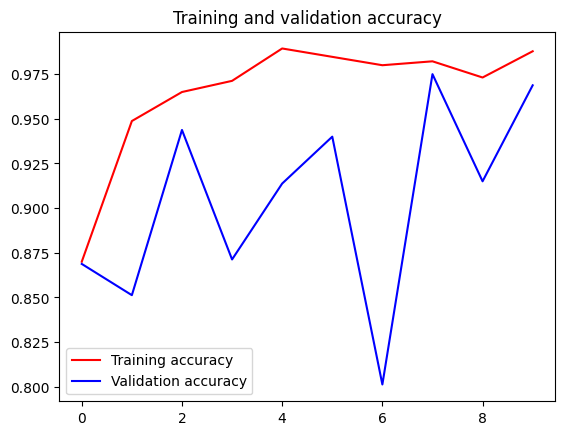

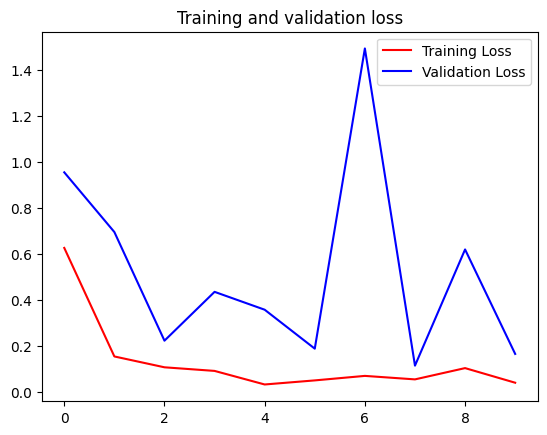

In [ ]:
plot_performance(history)

In [ ]:
train_accuracy = history.history['acc'][-1]  # Last epoch accuracy
test_accuracy = history.history['val_acc'][-1]  # Last epoch validation accuracy

# Print accuracies
print('Training accuracy:', train_accuracy)
print('Test accuracy:', test_accuracy)

Training accuracy: 0.9878125190734863
Test accuracy: 0.96875


<Figure size 2000x1500 with 0 Axes>

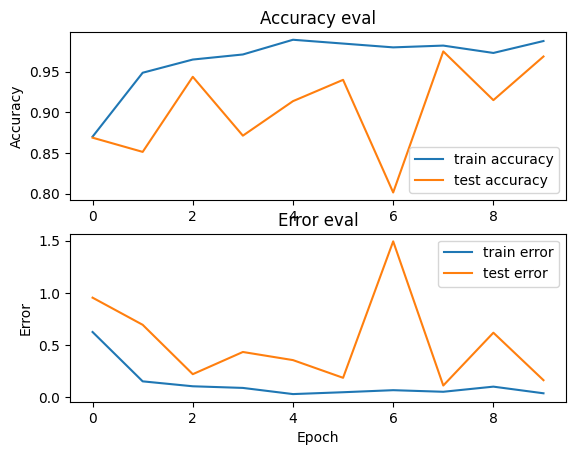

In [ ]:
plot_history(history)

In [ ]:
# Save the model to a file
with open('CNN14.pkl', 'wb') as file:
    pickle.dump(model, file)